In [156]:
import ann
import layers
nn = ann.ann_by_layers(layers = [layers.fc(20), layers.relu(), layers.fc(10)])

In [157]:
nn.layers

In [158]:
import numpy as np
x = np.arange(1,6)
x = x[:,None]
y = np.concatenate((2*x+1, 3-x))
y

array([[ 3],
       [ 5],
       [ 7],
       [ 9],
       [11],
       [ 2],
       [ 1],
       [ 0],
       [-1],
       [-2]])

In [159]:
def initialize_weight(sz):
    w = np.random.normal(size = sz)
    return w

# nn.layers[0].get_training_parameters()
# for this to be useful for initializing weights, I need to know the size given input data. 
# i.e. size information must be forwarded through the network

nn.layers[0].W = initialize_weight((20,5))
nn.layers[0].b = initialize_weight((20,1))
nn.layers[2].W = initialize_weight((10,20))
nn.layers[2].b = initialize_weight((10,1))

In [160]:
z = nn.layers[0].forward(x)
z.shape
z2 = nn.layers[2].forward(z)
z3 = nn.forward(x)
z3.shape

(10, 1)

In [161]:
loss = layers.mse()
loss.forward(z3, y)

2982.218041777701

In [162]:
params = []
xhat = x
for layer in nn.layers:
    params.append(layer.get_training_parameters(xhat))
    xhat = layer.forward(xhat)

In [163]:
dLdZ = loss.x_gradient(nn.forward(x),y)

In [164]:
getattr(nn.layers[0], params[0]['Weights']['Name'])
params

[{'Weights': {'Name': 'W', 'Gradient': array([[[1., 2., 3., 4., 5.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           ...,
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.]],
   
          [[0., 0., 0., 0., 0.],
           [1., 2., 3., 4., 5.],
           [0., 0., 0., 0., 0.],
           ...,
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.]],
   
          [[0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [1., 2., 3., 4., 5.],
           ...,
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.]],
   
          ...,
   
          [[0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           ...,
           [1., 2., 3., 4., 5.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.]],
   
          [[0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
   

In [165]:
# How to compute the backward for W in first fc layer.
# Essentially : use tensordot, and whatever your convention for where y is.
# I used the first dimension arbitrarily.

grad = params[0]['Weights']['Gradient']
print(grad.shape)
gradYDim = np.reshape(grad[:,0,0],(-1,1))
print(gradYDim.shape)
print(dLdZ.shape)
x1 = nn.layers[0].forward(x)
gradx1 = nn.layers[1].x_gradient(x1)
print(gradx1.shape)
gradx2 = nn.layers[2].x_gradient(nn.layers[1].forward(x1))
print(gradx2.shape)

firstProd = np.tensordot(gradx1,grad,(1,0))
secondProd = np.matmul(gradx2, firstProd)
backward = np.tensordot(dLdZ, secondProd, (0,1))
print(backward.shape)

# backward = np.tensordot(dLdZ, np.matmul(gradx2,np.tensordot(gradx1,grad,(2,1))),1
# print(backward.shape)

(20, 20, 5)
(20, 1)
(10, 1)
(20, 20)
(10, 20)
(1, 20, 5)


In [170]:
nn.layers[0].W = initialize_weight((20,5))
nn.layers[0].b = initialize_weight((20,1))
nn.layers[2].W = initialize_weight((10,20))
nn.layers[2].b = initialize_weight((10,1))
# Get updates via back prop

# Difficulties:
# 1: need to forward prop to the layer - cache this in an initial forward prop loop?
# 2: too many nested loops
# 3. getting gradients is a bit confusing with current set up. Using indexing to identify layers seems not great.
# 4. need to multiply over right dimensions in Weights derivative?

# Collect layer updates in an array/list - only makes sense for series/sequential architecture.
updates = []

# learning rate
step = 1e-3

# Loop over layers and associated list of parameter dictionaries
for i,layer_params in zip(range(len(params)),params):
    
    # create a layer_updates dictionary - same keys as layer_params - better implementation?
    layer_updates = {}
    
    # Loop over parameters in layer.
    for param in layer_params:
        
        # Compute intermediate/middle layer x-derivative product 
        # - only works if each layer is "x -> y"
        # So no multi-input/multi-output layers with this algo.
        
        # Initialise intermediate product as identity
        dxMidLayers = np.eye(nn.layers[2].NumHidden)
        
        # Recursively forward data for derivative computation and update dxMidLayers
        #- heavy nested loop could be computed initially and cached.
        for j in range(len(nn.layers)-1, i, -1):
            xhat = x
            for k in range(j):
                xhat = nn.layers[k].forward(xhat)
            dxMidLayers = np.matmul(dxMidLayers, nn.layers[j].x_gradient(xhat))
        
        # Apply outer layer derivatives
        #- i.e. the loss derivative in prediction argument
        # and the weights derivative of the associated layer.
        layer_updates[param] = {}
        print("Mid Layer gradient shape {}".format(dxMidLayers.shape))
        gradient = layer_params[param]['Gradient']
        print("Layer parameter gradient shape {}".format(gradient.shape))
        dLdW = np.tensordot(dxMidLayers, layer_params[param]['Gradient'],(1,0))
        
        # Use mse loss
        loss = layers.mse()
        dLdx = loss.x_gradient(nn.forward(x),y) # more wasteful forward computation here
        print(dLdx.shape)
        print(dLdW.shape)
        print(nn.layers[i].W.shape)
        update = step*(np.tensordot(dLdx, dLdW, (0,0)))
        shape = update.shape
        update = np.reshape(update, (shape[1],-1))
        print(update.shape)
        layer_updates[param]['Update'] = update
        layer_updates[param]['Name'] = layer_params[param]['Name']
    updates.append(layer_updates)

Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)


In [167]:
nn.layers[2].W_gradient(nn.layers[0].forward(x)).shape
params[2]['Weights']['Gradient'].shape

(10, 10, 20)

In [175]:
# Pain - the above backward creates updates with different shapes.
# Need to uniformise the data format.

for i in range(len(nn.layers)):
    update = updates[i]
    layer = nn.layers[i]
    for param in update:
        current = getattr(layer, update[param]['Name'])
        new = current - update[param]['Update']
        setattr(layer, update[param]['Name'], new)

In [179]:
print(nn.layers[2].b.shape)

(10, 1)


In [180]:
def compute_updates(nn, step):
    params = []
    xhat = x
    for layer in nn.layers:
        print(xhat.shape)
        params.append(layer.get_training_parameters(xhat))
        xhat = layer.forward(xhat)
    updates = []
    for i,layer_params in zip(range(len(params)),params):

        # create a layer_updates dictionary - same keys as layer_params - better implementation?
        layer_updates = {}

        # Loop over parameters in layer.
        for param in layer_params:

            # Compute intermediate/middle layer x-derivative product 
            # - only works if each layer is "x -> y"
            # So no multi-input/multi-output layers with this algo.

            # Initialise intermediate product as identity
            dxMidLayers = np.eye(nn.layers[2].NumHidden)

            # Recursively forward data for derivative computation and update dxMidLayers
            #- heavy nested loop could be computed initially and cached.
            for j in range(len(nn.layers)-1, i, -1):
                xhat = x
                for k in range(j):
                    xhat = nn.layers[k].forward(xhat)
                dxMidLayers = np.matmul(dxMidLayers, nn.layers[j].x_gradient(xhat))

            # Apply outer layer derivatives
            #- i.e. the loss derivative in prediction argument
            # and the weights derivative of the associated layer.
            layer_updates[param] = {}
            gradient = layer_params[param]['Gradient']
            dLdW = np.tensordot(dxMidLayers, layer_params[param]['Gradient'],(1,0))

            # Use mse loss
            loss = layers.mse()
            dLdx = loss.x_gradient(nn.forward(x),y) # more wasteful forward computation here
            update = step*(np.tensordot(dLdx, dLdW, (0,0)))
            shape = update.shape
            update = np.reshape(update, (shape[1],-1))
            layer_updates[param]['Update'] = update
            layer_updates[param]['Name'] = layer_params[param]['Name']
        updates.append(layer_updates)
    return updates

def update(nn, updates):
    for i in range(len(nn.layers)):
        update = updates[i]
        layer = nn.layers[i]
        for param in update:
            current = getattr(layer, update[param]['Name'])
            new = current - update[param]['Update']
            setattr(layer, update[param]['Name'], new)
        
def train(nn, iters, step):
    for iter in range(iters):
        updates = compute_updates(nn, step)
        update(nn, updates)
train(nn, 1,1e-3)

(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)


In [183]:
preds = []
for i in range(100):
    train(nn,10,1e-3)
    preds.append(nn.forward(x))

(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer p

(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parame

(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Lay

(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradi

Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape

(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradie

(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 1

(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape 

(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Lay

(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer paramete

(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Lay

(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer

(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape 

(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape 

(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer p

(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10

Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape

Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape

Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape

Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape

(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)

(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape 

(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20)
(10, 1)
(10, 20)
(20, 5)
(20, 1)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10, 20)
(10, 1)
(10, 10, 20)
(10, 20)
(10, 20)
Mid Layer gradient shape (10, 10)
Layer parameter gradient shape (10, 10)
(10, 1)
(10, 10)
(10, 20)
(10, 1)
(5, 1)
(20, 1)
(20, 1)
Mid Layer gradient shape (10, 20)
Layer parameter gradient shape (20, 20, 5)
(10, 1)
(10, 20, 5)
(20, 5)
(20, 5)
Mid Layer gradient shape (10, 20)
La

In [184]:
errors = []
for pred in preds:
    errors.append(np.square(np.sum(pred-y)))

<function matplotlib.pyplot.show(*args, **kw)>

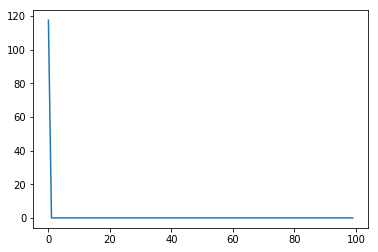

In [187]:
import matplotlib.pyplot as plt
plt.plot(errors)
plt.show

In [189]:
nn.forward(x) - y

array([[ 4.44089210e-16],
       [-1.77635684e-15],
       [-1.77635684e-15],
       [-1.77635684e-15],
       [ 3.55271368e-15],
       [ 4.44089210e-16],
       [-1.33226763e-15],
       [ 5.55111512e-16],
       [ 2.22044605e-16],
       [ 0.00000000e+00]])

### Woo!
Training seems to work in the very trivial case of predicting a single vector output from a single vector input.

#### Next:
Try training on more data points. This should help provoke thoughts about minibatching implementation.